In [ ]:
import os
import time
import io
from typing import Callable
from contextlib import contextmanager

import cv2
import torch
from skimage.data import astronaut
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import ipywidgets as widgets

from ibug.face_alignment import FANPredictor
from ibug.face_alignment.utils import plot_landmarks
from ibug.face_detection import RetinaFacePredictor

In [53]:
def detect_face(face_detector, image):
    detections = face_detector(image, rgb=False)
    assert len(detections) == 1, "Please submit an image with exactly one clear frontal face"
    return detections[0, :4]

def resize(image: np.ndarray, longer_side: int) -> np.ndarray:
    width, height = image.shape[:2]
    largest = max(width, height)
    ratio = longer_side / largest
    return cv2.resize(image, (int(height * ratio), int(width * ratio)))

@contextmanager
def time_tracking(callback: Callable[[float], None]):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        callback(end - start)
        

In [54]:
file_upload = widgets.FileUpload()

display(file_upload)

FileUpload(value={}, description='Upload')

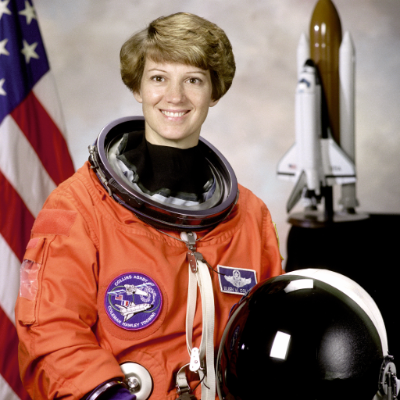

In [55]:
image = astronaut()

for filename, file_info in file_upload.value.items():
    image = np.array(Image.open(io.BytesIO(file_info['content'])))
    
image = resize(image, 400)
Image.fromarray(image)

In [58]:
device = "cpu"
if torch.cuda.is_available():
    device = torch.cuda.current_device()

face_detector = RetinaFacePredictor(
    device=device, 
    model=RetinaFacePredictor.get_model("mobilenet0.25"),
)

with time_tracking(print):
    detection = detect_face(face_detector, image)
print(f"Detected face at {detection=}")

config = FANPredictor.create_config(
    gamma = 1.0, 
    radius = 0.1, 
    use_jit = False,
)

fan = FANPredictor(
    device=device, 
    model=FANPredictor.get_model('2dfan2_alt'), 
    config=config,
)
with time_tracking(print):
    landmarks, scores = fan(image, detection)

0.02904645800299477
Detected face at detection=array([142.84244 ,  45.635033, 212.85872 , 136.84912 ], dtype=float32)
0.18647570800385438


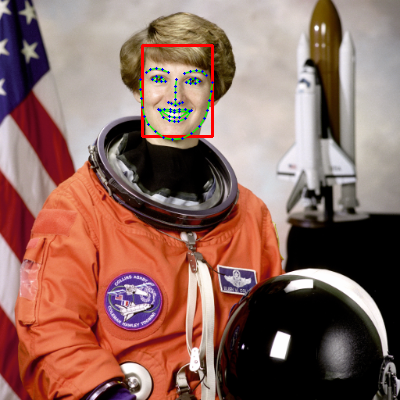

In [59]:
vis = image.copy()
cv2.rectangle(
    vis, 
    detection[:2].astype(np.int32), 
    detection[2:].astype(np.int32), 
    color=(255, 0, 0),
    thickness=2,
)
plot_landmarks(vis, landmarks[0])


Image.fromarray(vis)